In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob  # glob to get the .jpg file

In [ ]:
def is_inRange_RGB(x, low=10, high=90):
    return (x >= low) & (x <= high)

def is_near_rgb(r, g, b, range=20):
    return (
        (np.absolute(r - b) <= range) &
        (np.absolute(g - b) <= range) &
        (np.absolute(r - g) <= range)
    )

def is_inRange_HSV(h, s, v):
    return (
        ((s <= 25) & ((v >= 45) & (v <= 75))) |
        (((s >= 90) & (s <= 155)) & ((v >= 20) & (v <= 45))) |
        (((s >= 5) & (s <= 15)) & ((v >= 70) & (v <= 100)))
    )

======================== *0* ========================


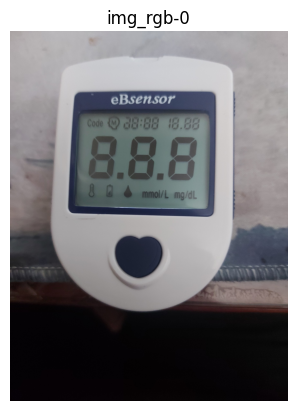

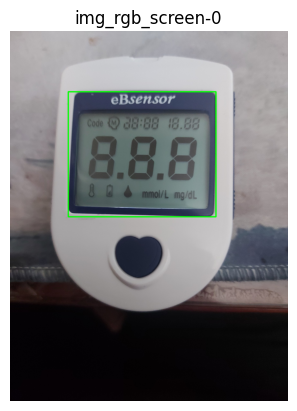

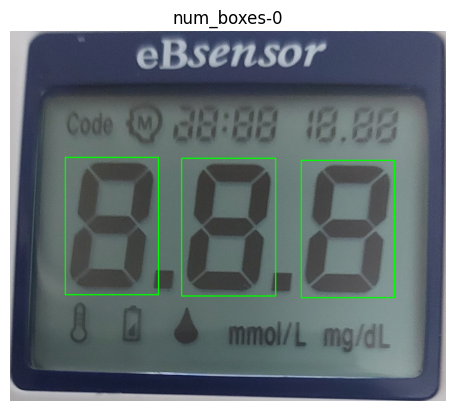

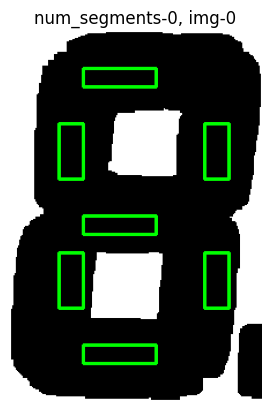

8


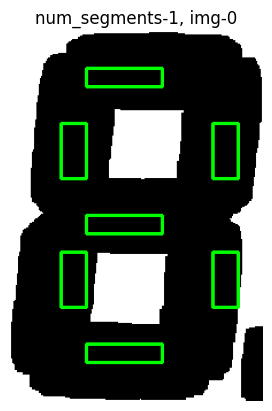

8


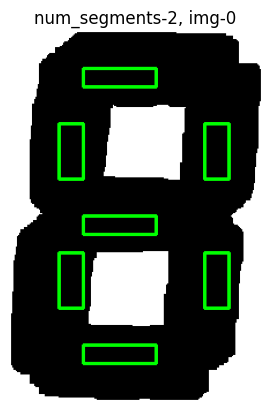

8
Output: 888
======================== *1* ========================


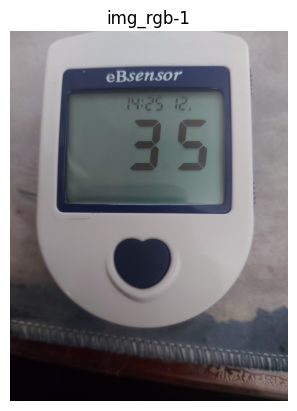

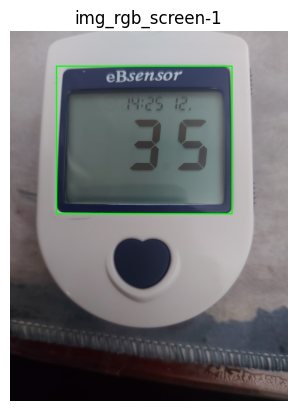

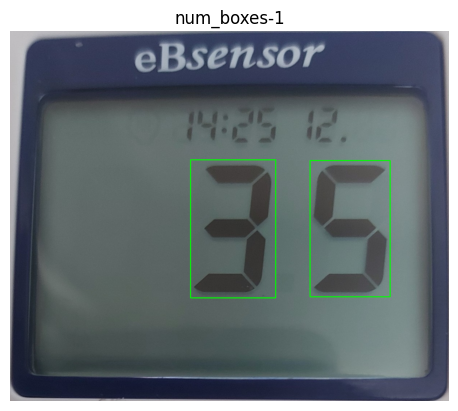

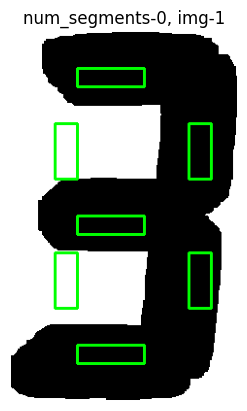

3


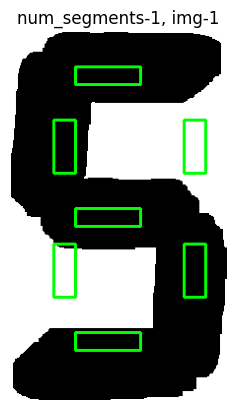

5
Output: 35
======================== *2* ========================


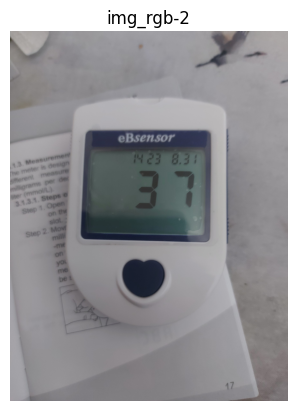

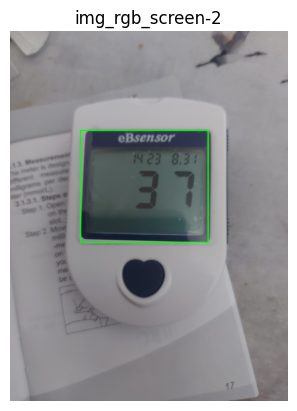

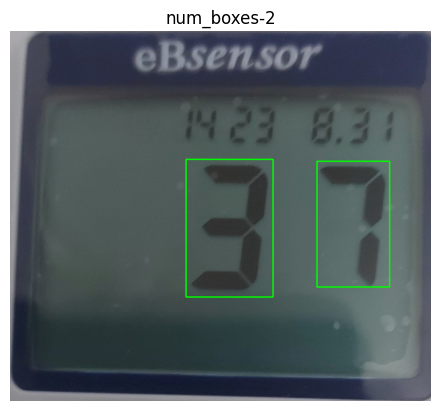

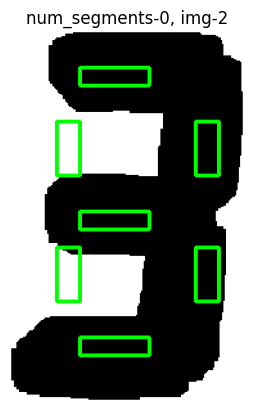

3


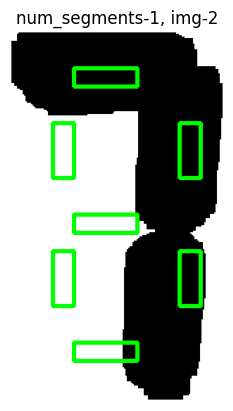

7
Output: 37
======================== *3* ========================


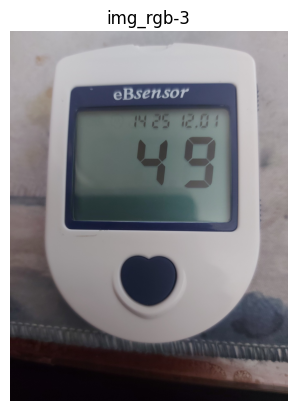

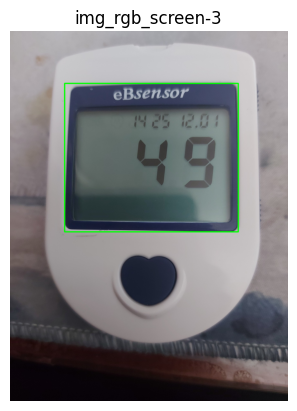

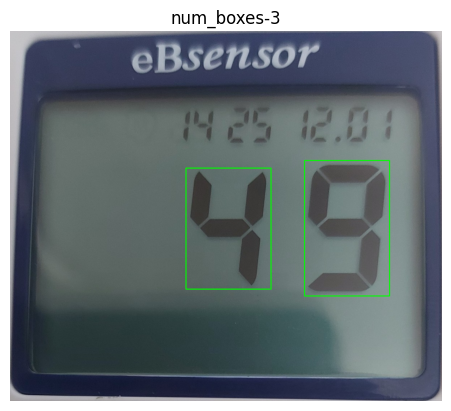

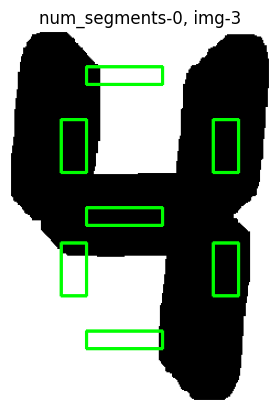

4


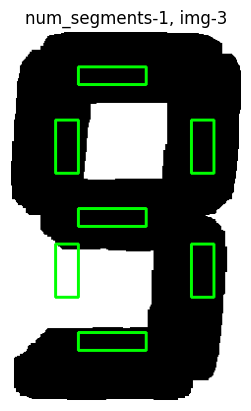

9
Output: 49
======================== *4* ========================


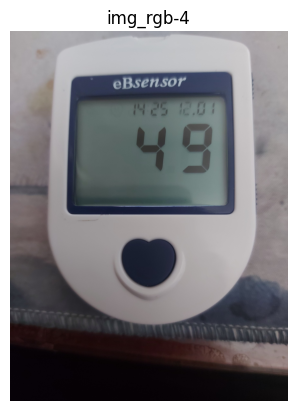

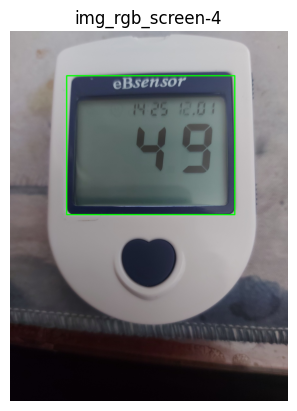

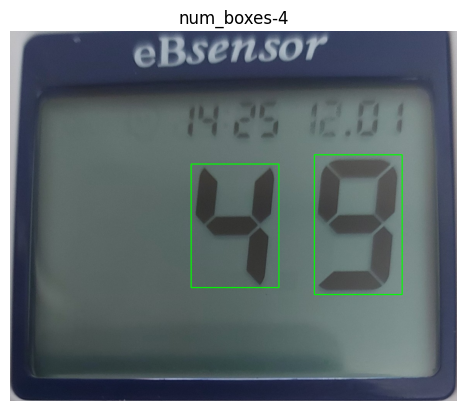

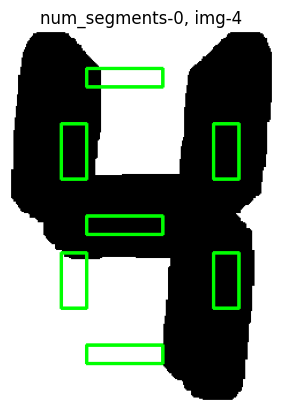

4


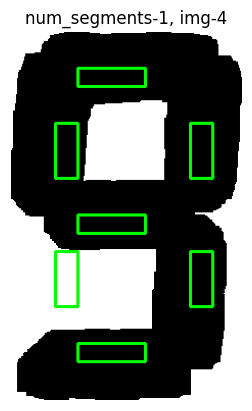

9
Output: 49
======================== *5* ========================


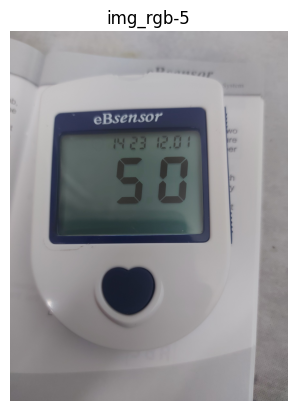

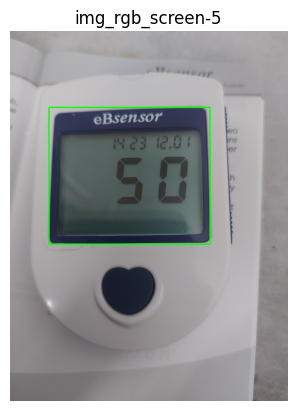

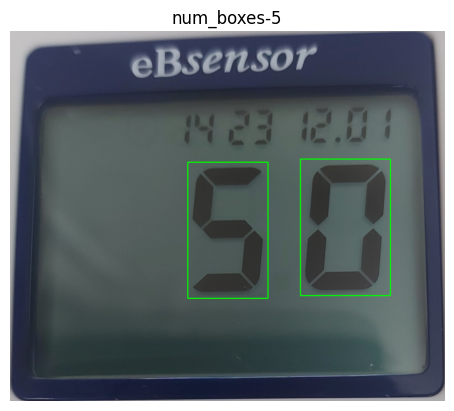

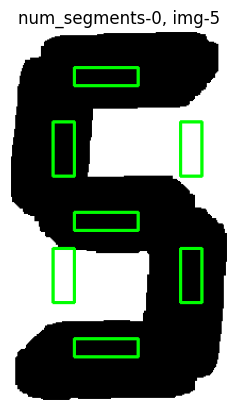

5


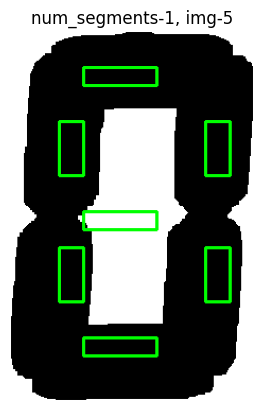

0
Output: 50
======================== *6* ========================


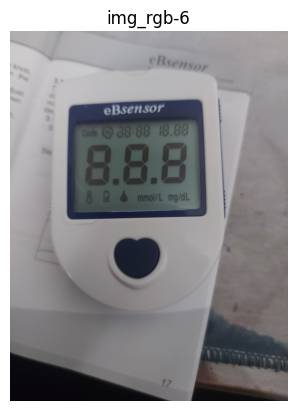

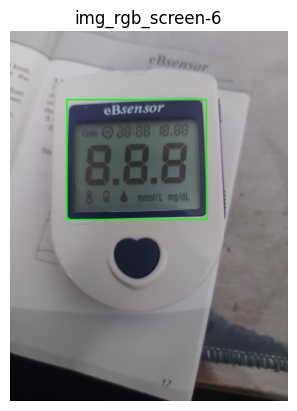

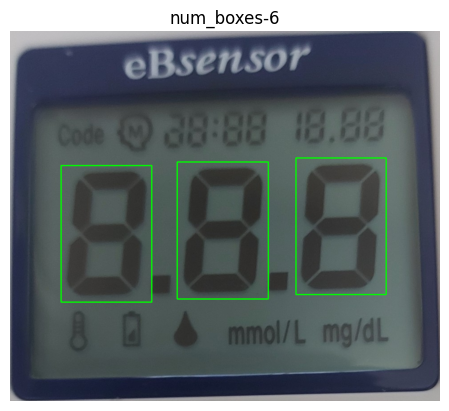

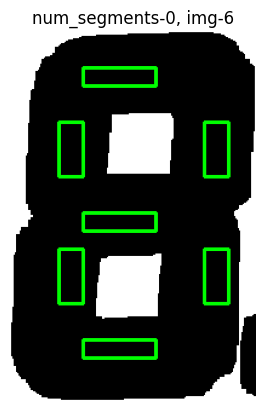

8


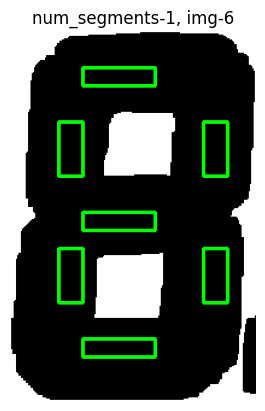

8


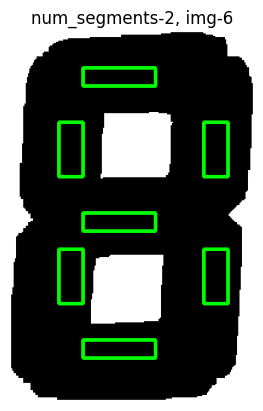

8
Output: 888
======================== *7* ========================


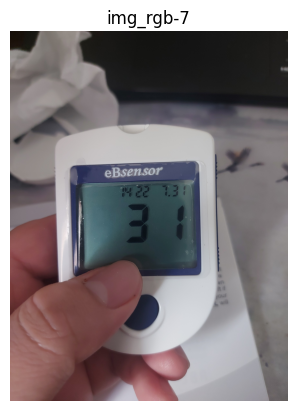

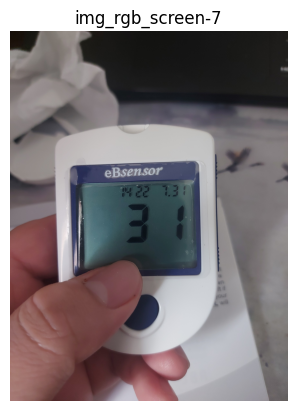

!!!CAN NOT FIND SCREEN. PLEASE MAKE SURE YOU GET THE FULL SCREEN WITHOUT OBSTACLES!!!
======================== *8* ========================


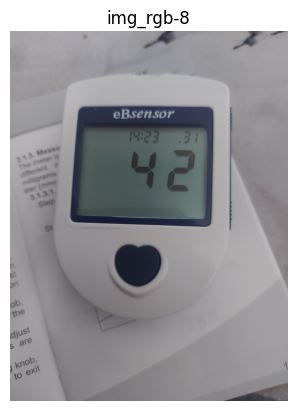

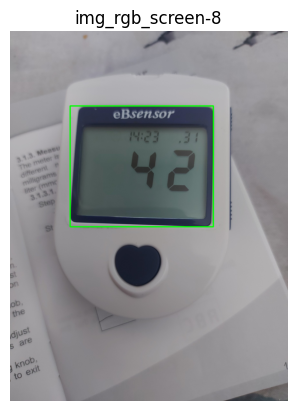

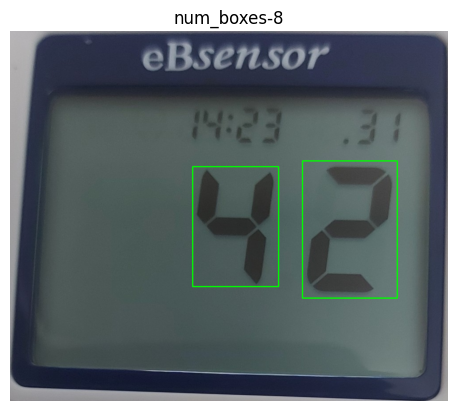

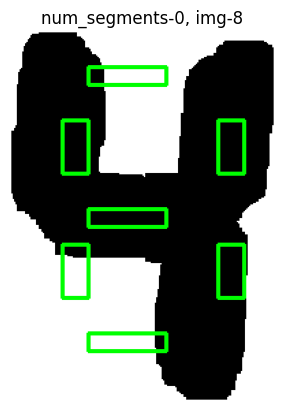

4


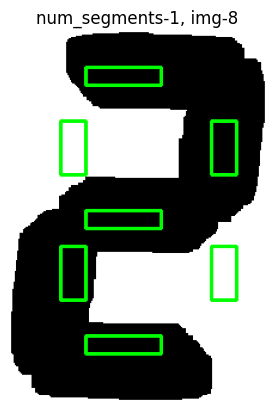

2
Output: 42


In [71]:
images = glob.glob("/content/drive/MyDrive/Colab Notebooks/num_detect/data/*.jpg")  # a list of images in a folder

for i, img_path in enumerate(images):
    print(f"======================== *{i}* ========================")
    # Import the image and divide into multiple color types
    img_bgr = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(img_gray, 98, 255, cv2.THRESH_BINARY)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"img_rgb-{i}")
    plt.axis("off")
    plt.show()

    # Step 1: Find contour of the screen then crop the screen
    # 1. Detect edges with Canny
    canny_edges = cv2.Canny(img_bin, 80, 200)

    # 2. Find image's contours with the Canny edges
    img_contours, _ = cv2.findContours(
        canny_edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE
    )
    canny_edges_copy = cv2.cvtColor(canny_edges.copy(), cv2.COLOR_GRAY2RGB)

    # 3. Find the contour with the suitable width and height
    img_rgb_copy = img_rgb.copy()
    screen = np.ones((1,1))  # placeholder
    for contour in img_contours:
        x, y, w, h = cv2.boundingRect(contour)
        ratio = h/w
        if ratio >= 0.8 and ratio <= 1.0  and w >= 800 and h >= 600:
            cv2.rectangle(img_rgb_copy, (x, y), (x + w, y + h), (0, 255, 0), 8)
            screen = img_rgb[y:y + h, x: x + w]
            pass
        else:
            continue

    plt.imshow(img_rgb_copy)
    plt.title(f"img_rgb_screen-{i}")
    plt.axis("off")
    plt.show()

    if (screen.shape == (1, 1)):
        print("\033[31m!!!CAN NOT FIND SCREEN. PLEASE MAKE SURE YOU GET THE FULL SCREEN WITHOUT OBSTACLES!!!\033[0m")
        continue

    # Step 2: Wrap boxes around the numbers
    # 1. Change screen to binary
    screen_gray = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    screen_hsv = cv2.cvtColor(screen, cv2.COLOR_RGB2HSV)
    screen = screen.astype("int16")  # change from uint8 to int16
    r, g, b = screen[:, :, 0], screen[:, :, 1], screen[:, :, 2]
    h, s, v = screen_hsv[:, :, 0], screen_hsv[:, :, 1], screen_hsv[:, :, 2]
    mask = (
        is_inRange_RGB(r) &  # Red
        is_inRange_RGB(g) &  # Green
        is_inRange_RGB(b) &  # Blue
        is_near_rgb(r, g, b) &
        is_inRange_HSV(h, s, v)
    )
    screen_bin = np.full_like(screen_gray, 255)  # Bg color
    screen_bin[mask] = 0  # Fg color
    screen_bin = screen_bin.astype("uint8")  # change from int16 to uint8
    screen = screen.astype("uint8")  # change from int16 to uint8
    _, screen_bin = cv2.threshold(screen_bin, 175, 255, cv2.THRESH_BINARY)

    # 2. Use dilation to connect the segments
    dilation_kernel = np.ones((25, 25), np.uint8)
    # since cv2.dilate will expand the white pixels, we need to inverse the screen, dilate it, then reverse again
    negative = 255 - screen_bin
    dilation = cv2.dilate(negative, dilation_kernel, 3, anchor=(-1, -1))
    dilation = 255 - dilation
    dilation = dilation.astype("uint8")  # change from int16 to uint8

    # 3. Find contours of the numbers, then wrap a box around them
    screen_contours, _ = cv2.findContours(
        dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE
    )
    screen_copy = screen.copy()

    num_boxes = []
    for contour in screen_contours:
        x, y, w, h = cv2.boundingRect(contour)
        ratio = w/h  # Note that this ratio is different from the ratio above
        if ratio <= 1.0 and (w >= 50 and w <= 300) and (h >= 250 and h <= 400) and y <= 500:
            if ratio >= 0.28 and ratio <=0.35:  # special case: number is 1. Fix: expand the width of the box
                x -= int(screen_bin.shape[0] / 8)
                w += int(screen_bin.shape[0] / 8)
            cv2.rectangle(screen_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
            num_boxes.append((x, y, w, h))
        else:
            pass
    num_boxes = sorted(num_boxes, key=lambda num_rect: num_rect[0])  # sort the boxes from left to right to make sure the correct order

    plt.imshow(screen_copy)
    plt.title(f"num_boxes-{i}")
    plt.axis("off")
    plt.show()

    # Step 3: Detect the number in each box
    output = ""
    #     -----0-----
    #     |         |
    #     1         2
    #     |         |
    #     -----3-----
    #     |         |
    #     4         5
    #     |         |
    #     -----6-----
    num_dictionary = {  # a dictionary to help detected the segements
# Segments: 0, 1, 2, 3, 4, 5, 6
           (1, 1, 1, 0, 1, 1, 1): "0",
           (0, 0, 1, 0, 0, 1, 0): "1",
           (1, 0, 1, 1, 1, 0, 1): "2",
           (1, 0, 1, 1, 0, 1, 1): "3",
           (0, 1, 1, 1, 0, 1, 0): "4",
           (1, 1, 0, 1, 0, 1, 1): "5",
           (1, 1, 0, 1, 1, 1, 1): "6",
           (1, 0, 1, 0, 0, 1, 0): "7",
           (1, 1, 1, 1, 1, 1, 1): "8",
           (1, 1, 1, 1, 0, 1, 1): "9",
    }

    for j, box in enumerate(num_boxes):
        x, y, w, h = box

        # 1. Crop the number from the dilated screen above
        num_bin = dilation[y:y + h, x:x + w]

        # 2. Create 7 boxes at the corresponding segment places
        h_frac = int(h/20)
        w_frac = int(w/10)
        segments = [
            num_bin[2*h_frac: 3*h_frac, 3*w_frac: 6*w_frac],    # seg_0
            num_bin[5*h_frac: 8*h_frac, 2*w_frac: 3*w_frac],    # seg_1
            num_bin[5*h_frac: 8*h_frac, 8*w_frac: 9*w_frac],    # seg_2
            num_bin[10*h_frac: 11*h_frac, 3*w_frac: 6*w_frac],  # seg_3
            num_bin[12*h_frac: 15*h_frac, 2*w_frac: 3*w_frac],  # seg_4
            num_bin[12*h_frac: 15*h_frac, 8*w_frac: 9*w_frac],  # seg_5
            num_bin[17*h_frac: 18*h_frac, 3*w_frac: 6*w_frac],  # seg_6
        ]

        # draw the rectangle on the segments to check which one is active
        num_bin_copy = num_bin.copy()
        num_bin_copy = cv2.cvtColor(num_bin_copy, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(num_bin_copy, (3*w_frac, 2*h_frac), (6*w_frac, 3*h_frac), (0, 255, 0), 2)
        cv2.rectangle(num_bin_copy, (2*w_frac, 5*h_frac), (3*w_frac, 8*h_frac), (0, 255, 0), 2)
        cv2.rectangle(num_bin_copy, (8*w_frac, 5*h_frac), (9*w_frac, 8*h_frac), (0, 255, 0), 2)
        cv2.rectangle(num_bin_copy, (3*w_frac, 10*h_frac), (6*w_frac, 11*h_frac), (0, 255, 0), 2)
        cv2.rectangle(num_bin_copy, (2*w_frac, 12*h_frac), (3*w_frac, 15*h_frac), (0, 255, 0), 2)
        cv2.rectangle(num_bin_copy, (8*w_frac, 12*h_frac), (9*w_frac, 15*h_frac), (0, 255, 0), 2)
        cv2.rectangle(num_bin_copy, (3*w_frac, 17*h_frac), (6*w_frac, 18*h_frac), (0, 255, 0), 2)
        plt.imshow(num_bin_copy)
        plt.title(f"num_segments-{j}, img-{i}")
        plt.axis("off")
        plt.show()

        # 3. In each seg_n, count the number 1 then divide them by the total pixels. If res >= 80%, mark the segment as active
        active_segments = ()
        for seg in segments:
            total_pixels = seg.shape[0] * seg.shape[1]
            active_pixels = (seg == 0).sum()
            res = (active_pixels / total_pixels) * 100
            if res >= 80:
              active_segments += (1,)
            else:
              active_segments += (0,)

        if active_segments in num_dictionary:
          print(num_dictionary[active_segments])
          output += num_dictionary[active_segments]
        else:
          print("X")
          output += "X"

    print(f"Output: {output}")